In [1]:
import os
import zipfile
import requests

# Destination folder
DATASET_DIR = "dataset_eurosat_sample"
os.makedirs(DATASET_DIR, exist_ok=True)

# EuroSAT RGB dataset from Zenodo
URL = "https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip"
ZIP_PATH = "EuroSAT_RGB.zip"

# Download if not already
if not os.path.exists(ZIP_PATH):
    print("Downloading EuroSAT RGB dataset (~88 MB)...")
    r = requests.get(URL, stream=True)
    with open(ZIP_PATH, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

# Extract
print("Extracting...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("eurosat_data")

print("Done!")


Extracting...
Done!


In [2]:
import shutil
from pathlib import Path

base_path = Path("/content/eurosat_data/EuroSAT_RGB")
DATASET_PATH = Path("dataset_eurosat_sample/")
DATASET_PATH.mkdir(exist_ok=True)

classes = ["AnnualCrop", "Forest", "River", "Residential"]
num_to_copy = 20  # per class

for cls in classes:
    class_folder = base_path / cls
    images = list(class_folder.glob("*.jpg"))
    print(f"{cls}: {len(images)} images available")
    for src in images[:num_to_copy]:
        shutil.copy(src, DATASET_PATH / f"{cls}_{src.name}")

print("Copied sample images into dataset_eurosat_sample/")


AnnualCrop: 3000 images available
Forest: 3000 images available
River: 2500 images available
Residential: 3000 images available
Copied sample images into dataset_eurosat_sample/


In [3]:
!pip install faiss-cpu --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 51.4 MB/s eta 0:00:00


In [4]:
import os
import json
import warnings
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any
import pickle

# Data handling
import numpy as np
from PIL import Image
import tifffile  # For GeoTIFF support

# Deep Learning
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Similarity search
import faiss

# Utilities
from sklearn.preprocessing import normalize
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Using device: cpu
Initializing patch-based CBIR system...
Found 82 images in /content/dataset_eurosat_sample
Loading patch feature extractor...
Loading existing patch FAISS index...
Patch index loaded. Total patches: 16072

Searching for similar patches...

Found 26 images with matching patches:
  1. 01.png: 1913 patches matched, best similarity = 1.000, avg similarity = 0.660
  2. Residential_Residential_2437.jpg: 3 patches matched, best similarity = 0.615, avg similarity = 0.531
  3. AnnualCrop_AnnualCrop_150.jpg: 1 patches matched, best similarity = 0.576, avg similarity = 0.576
  4. Residential_Residential_2733.jpg: 2 patches matched, best similarity = 0.574, avg similarity = 0.509
  5. AnnualCrop_AnnualCrop_848.jpg: 1 patches matched, best similarity = 0.562, avg similarity = 0.562
  6. River_River_69.jpg: 2 patches matched, best similarity = 0.560, avg similarity = 0.526
  7. Forest_Forest_536.jpg: 3 patches matched, best similarity = 0.555, avg similarity = 0.527
  8. River_Rive

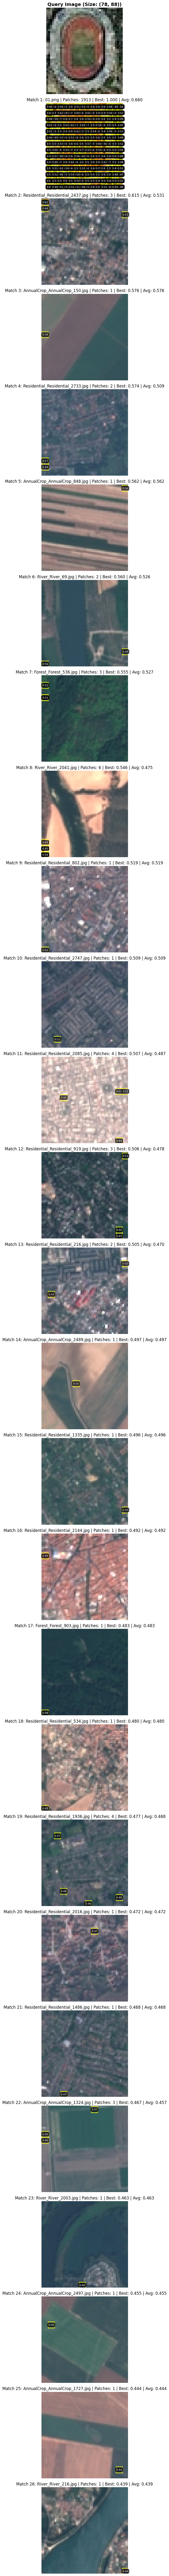

[{'path': '/content/dataset_eurosat_sample/01.png',
  'image_idx': 1,
  'patches': [{'position': (0, 0),
    'similarity': 1.0000001192092896,
    'patch_idx': 196,
    'query_position': (0, 0)},
   {'position': (1, 0),
    'similarity': 0.6303011178970337,
    'patch_idx': 210,
    'query_position': (0, 0)},
   {'position': (0, 1),
    'similarity': 0.6223850846290588,
    'patch_idx': 197,
    'query_position': (0, 0)},
   {'position': (0, 11),
    'similarity': 0.5867304801940918,
    'patch_idx': 207,
    'query_position': (0, 0)},
   {'position': (0, 12),
    'similarity': 0.5731076002120972,
    'patch_idx': 208,
    'query_position': (0, 0)},
   {'position': (0, 1),
    'similarity': 1.0,
    'patch_idx': 197,
    'query_position': (0, 1)},
   {'position': (1, 0),
    'similarity': 0.664177656173706,
    'patch_idx': 210,
    'query_position': (0, 1)},
   {'position': (0, 11),
    'similarity': 0.6436967849731445,
    'patch_idx': 207,
    'query_position': (0, 1)},
   {'positio

In [10]:
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import tifffile
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional
from tqdm import tqdm
from sklearn.preprocessing import normalize
import faiss
import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------------- Config ----------------------------
class Config:
    DATASET_PATH = "/content/dataset_eurosat_sample"
    CACHE_DIR = "cbir_cache_patch/"
    IMAGE_SIZE = (224, 224)  # Input size for ResNet
    BATCH_SIZE = 8  # Lower batch size for feature map extraction
    NUM_WORKERS = 4
    MODEL_NAME = "resnet50"

    # Patch-based retrieval settings
    FEATURE_MAP_LEVEL = "layer3"  # use layer3
    PATCH_EMBEDDING_DIM = 1024    # layer3 has 1024 channels
    TOP_K = 10
    SIMILARITY_THRESHOLD = 0.3

    # Feature map spatial dimensions for ResNet50 with 224x224 input
    FEATURE_MAP_SIZE = 14  # layer3 outputs 14x14 grid
    RECEPTIVE_FIELD_SIZE = 16  # Approximate receptive field per feature

    IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp')

os.makedirs(Config.CACHE_DIR, exist_ok=True)

# ---------------------------- Helper Functions ----------------------------
def load_satellite_image(image_path: str) -> np.ndarray:
    """Load satellite image and convert to RGB numpy array."""
    try:
        if image_path.lower().endswith(('.tif', '.tiff')):
            img = tifffile.imread(image_path)
            if img.ndim == 3:
                if img.shape[0] < img.shape[2]:
                    img = np.transpose(img, (1, 2, 0))
                if img.shape[2] >= 3:
                    img = img[:, :, :3]
                else:
                    img = np.stack([img[:, :, 0]] * 3, axis=2)
            elif img.ndim == 2:
                img = np.stack([img] * 3, axis=2)
            if img.dtype != np.uint8:
                img = ((img - img.min()) / (img.max() - img.min() + 1e-6) * 255).astype(np.uint8)
            return img
        else:
            img = Image.open(image_path).convert('RGB')
            return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return np.zeros((224, 224, 3), dtype=np.uint8)

# ---------------------------- Dataset ----------------------------
class SatelliteImageDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, extensions=Config.IMAGE_EXTENSIONS):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = self._find_images(extensions)
        self.images_cache = {}
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def _find_images(self, extensions: tuple) -> List[Path]:
        image_paths = []
        for ext in extensions:
            image_paths.extend(self.root_dir.glob(f"**/*{ext}"))
            image_paths.extend(self.root_dir.glob(f"**/*{ext.upper()}"))
        return sorted(list(set(image_paths)))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        img_path = self.image_paths[idx]
        if idx not in self.images_cache:
            img_array = load_satellite_image(str(img_path))
            self.images_cache[idx] = img_array
        else:
            img_array = self.images_cache[idx]

        img = Image.fromarray(img_array)
        original_size = img.size

        if self.transform:
            img_tensor = self.transform(img)
        else:
            img_tensor = transforms.ToTensor()(img)

        return {
            'image': img_tensor,
            'path': str(img_path),
            'idx': idx,
            'original_size': original_size
        }

    def get_raw_image(self, idx: int) -> np.ndarray:
        if idx not in self.images_cache:
            img_path = self.image_paths[idx]
            self.images_cache[idx] = load_satellite_image(str(img_path))
        return self.images_cache[idx]

# ---------------------------- Feature Extractor with Patch Support ----------------------------
class PatchFeatureExtractor(nn.Module):
    """
    Extract feature maps from intermediate layers of ResNet.
    """
    def __init__(self, model_name: str = 'resnet50', pretrained: bool = True):
        super().__init__()

        if model_name == 'resnet50':
            base_model = models.resnet50(pretrained=pretrained)
            # Extract features up to layer3
            self.conv1 = base_model.conv1
            self.bn1 = base_model.bn1
            self.relu = base_model.relu
            self.maxpool = base_model.maxpool
            self.layer1 = base_model.layer1
            self.layer2 = base_model.layer2
            self.layer3 = base_model.layer3
            self.layer4 = base_model.layer4  # still available for global embedding if needed
            self.patch_dim = 1024
            self.feature_map_size = 14  # For 224x224 input
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def forward_feature_map(self, x: torch.Tensor) -> torch.Tensor:
        """
        Extract feature map from layer3.
        Returns: [B, C, H, W] where C=1024, H=W=14 for 224x224 input
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        return x

    def extract_patch_embeddings(self, x: torch.Tensor) -> Tuple[torch.Tensor, List[Tuple[int, int]]]:
        """Extract patch embeddings from feature map."""
        feature_map = self.forward_feature_map(x)
        B, C, H, W = feature_map.shape

        patch_embeddings = feature_map.permute(0, 2, 3, 1).reshape(-1, C)

        positions = []
        for b in range(B):
            for y in range(H):
                for x_pos in range(W):
                    positions.append((y, x_pos))

        return patch_embeddings, positions

    def extract_global_embedding(self, x: torch.Tensor) -> torch.Tensor:
        """Extract global embedding using layer4 (more semantic)."""
        # Go through full network up to layer4
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        global_embedding = F.adaptive_avg_pool2d(x, (1, 1))
        return global_embedding.view(x.size(0), -1)

# ---------------------------- FAISS Index for Patches ----------------------------
class PatchFAISSIndex:
    def __init__(self, embedding_dim: int, similarity_metric: str = 'cosine'):
        self.embedding_dim = embedding_dim
        self.similarity_metric = similarity_metric

        if similarity_metric == 'cosine':
            self.index = faiss.IndexFlatIP(embedding_dim)
        elif similarity_metric == 'l2':
            self.index = faiss.IndexFlatL2(embedding_dim)
        else:
            raise ValueError(f"Unsupported metric: {similarity_metric}")

        self.is_trained = False
        self.patch_metadata = []

    def build_from_patches(self, patch_embeddings: np.ndarray,
                          image_paths: List[str],
                          image_indices: List[int],
                          positions: List[Tuple[int, int]]):
        patch_embeddings = patch_embeddings.astype(np.float32)
        if self.similarity_metric == 'cosine':
            patch_embeddings = normalize(patch_embeddings, norm='l2')

        self.index.add(patch_embeddings)

        patches_per_image = len(positions) // len(image_paths)
        for img_idx, (img_path, img_index) in enumerate(zip(image_paths, image_indices)):
            for pos_idx in range(patches_per_image):
                y, x = positions[img_idx * patches_per_image + pos_idx]
                self.patch_metadata.append({
                    'image_path': img_path,
                    'image_idx': img_index,
                    'position': (y, x)
                })

        self.is_trained = True
        print(f"Patch index built with {self.index.ntotal} patches from {len(image_paths)} images")

    def search(self, query_embedding: np.ndarray, k: int = 10) -> Tuple[np.ndarray, np.ndarray, List[Dict]]:
        if not self.is_trained:
            raise ValueError("Index not built yet.")

        if query_embedding.ndim == 1:
            query_embedding = query_embedding.reshape(1, -1)

        query_embedding = query_embedding.astype(np.float32)
        if self.similarity_metric == 'cosine':
            query_embedding = normalize(query_embedding, norm='l2')

        distances, indices = self.index.search(query_embedding, k)

        matched_metadata = []
        for idx in indices[0]:
            if idx < len(self.patch_metadata):
                matched_metadata.append(self.patch_metadata[idx])
            else:
                matched_metadata.append(None)

        return distances[0], indices[0], matched_metadata

    def save(self, path: str):
        faiss.write_index(self.index, path)
        metadata_path = path.replace('.index', '_metadata.pkl')
        with open(metadata_path, 'wb') as f:
            pickle.dump(self.patch_metadata, f)
        print(f"Patch index saved to {path}")

    def load(self, path: str):
        self.index = faiss.read_index(path)
        self.is_trained = True
        metadata_path = path.replace('.index', '_metadata.pkl')
        if os.path.exists(metadata_path):
            with open(metadata_path, 'rb') as f:
                self.patch_metadata = pickle.load(f)
        print(f"Patch index loaded. Total patches: {self.index.ntotal}")

# ---------------------------- Extraction and Search Functions ----------------------------
def extract_dataset_patch_embeddings(feature_extractor: PatchFeatureExtractor,
                                    dataloader: DataLoader,
                                    cache_path: str = None) -> Tuple[np.ndarray, List[str], List[int], List[Tuple[int, int]]]:
    if cache_path and os.path.exists(cache_path):
        data = np.load(cache_path, allow_pickle=True)
        return (data['embeddings'],
                data['paths'].tolist(),
                data['indices'].tolist(),
                [tuple(p) for p in data['positions']])

    embeddings_list = []
    paths_list = []
    indices_list = []
    all_positions = []

    feature_extractor.eval()
    with torch.no_grad():
        for batch_data in tqdm(dataloader, desc="Extracting patch features"):
            images = batch_data['image'].to(device)

            patch_embeddings, positions = feature_extractor.extract_patch_embeddings(images)
            patch_embeddings_np = normalize(patch_embeddings.cpu().numpy(), norm='l2')

            batch_size = images.size(0)
            patches_per_image = len(positions) // batch_size

            for i in range(batch_size):
                start_idx = i * patches_per_image
                end_idx = (i + 1) * patches_per_image
                image_patches = patch_embeddings_np[start_idx:end_idx]
                embeddings_list.append(image_patches)

                paths_list.append(batch_data['path'][i])
                indices_list.append(batch_data['idx'][i].item())
                all_positions.extend(positions[start_idx:end_idx])

    embeddings = np.vstack(embeddings_list)

    if cache_path:
        np.savez_compressed(cache_path,
                          embeddings=embeddings,
                          paths=np.array(paths_list),
                          indices=np.array(indices_list),
                          positions=np.array(all_positions))

    return embeddings, paths_list, indices_list, all_positions

def search_patches(query_image: Image.Image,
                  feature_extractor: PatchFeatureExtractor,
                  patch_index: PatchFAISSIndex,
                  transform,
                  top_k: int = 10,
                  threshold: float = 0.3) -> List[Dict]:
    """
    Search for similar patches using patch-level features.
    This version uses the query image's patches to search the index.
    """
    query_tensor = transform(query_image).unsqueeze(0).to(device)

    feature_extractor.eval()
    with torch.no_grad():
        # Extract patch embeddings from the query image (same layer as index)
        query_patch_embeddings, query_positions = feature_extractor.extract_patch_embeddings(query_tensor)
        query_patch_embeddings_np = normalize(query_patch_embeddings.cpu().numpy(), norm='l2')

    # Aggregate results across all query patches
    all_matches = {}

    # For each patch in the query image, search for similar patches
    for i, query_patch in enumerate(query_patch_embeddings_np):
        distances, indices, metadata = patch_index.search(query_patch.reshape(1, -1), k=top_k)

        for dist, idx, meta in zip(distances, indices, metadata):
            if meta is None or dist < threshold:
                continue

            img_path = meta['image_path']
            if img_path not in all_matches:
                all_matches[img_path] = {
                    'path': img_path,
                    'image_idx': meta['image_idx'],
                    'patches': []
                }

            all_matches[img_path]['patches'].append({
                'position': meta['position'],
                'similarity': float(dist),
                'patch_idx': int(idx),
                'query_position': query_positions[i]
            })

    # Convert to list and sort by best similarity
    results = list(all_matches.values())
    for result in results:
        result['best_similarity'] = max(p['similarity'] for p in result['patches'])
        result['avg_similarity'] = sum(p['similarity'] for p in result['patches']) / len(result['patches'])

    results.sort(key=lambda x: x['best_similarity'], reverse=True)

    return results

def visualize_patch_matches(query_image: Image.Image,
                           search_results: List[Dict],
                           feature_map_size: int = 14,
                           top_k_images: int = None):
    # Show all results if top_k_images is None, otherwise limit to top_k_images
    n_results = len(search_results) if top_k_images is None else min(len(search_results), top_k_images)

    fig = plt.figure(figsize=(20, 4 * (n_results + 1)))

    # Show query image
    ax = plt.subplot(n_results + 1, 1, 1)
    plt.imshow(query_image)
    plt.title(f'Query Image (Size: {query_image.size})', fontsize=14, fontweight='bold')
    plt.axis('off')

    # Show matched images with highlighted patches
    for idx, result in enumerate(search_results[:n_results]):
        ax = plt.subplot(n_results + 1, 1, idx + 2)
        matched_img = Image.open(result['path']).convert('RGB')
        plt.imshow(matched_img)

        img_w, img_h = matched_img.size
        patch_w = img_w / feature_map_size
        patch_h = img_h / feature_map_size

        # Draw rectangles for matched patches
        for patch_info in result['patches']:
            y, x = patch_info['position']
            similarity = patch_info['similarity']

            # Color code based on similarity
            if similarity > 0.8:
                color = 'red'
            elif similarity > 0.6:
                color = 'orange'
            else:
                color = 'yellow'

            rect = patches.Rectangle(
                (x * patch_w, y * patch_h),
                patch_w, patch_h,
                linewidth=2,
                edgecolor=color,
                facecolor='none',
                alpha=0.8
            )
            ax.add_patch(rect)

            # Add similarity score text
            ax.text(x * patch_w + patch_w/2, y * patch_h + patch_h/2,
                   f'{similarity:.2f}',
                   color='white',
                   fontsize=8,
                   ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

        plt.title(f'Match {idx+1}: {os.path.basename(result["path"])} | '
                 f'Patches: {len(result["patches"])} | Best: {result["best_similarity"]:.3f} | '
                 f'Avg: {result["avg_similarity"]:.3f}',
                 fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# ---------------------------- Main Pipeline ----------------------------
def get_transforms():
    return transforms.Compose([
        transforms.Resize(Config.IMAGE_SIZE),
        transforms.CenterCrop(Config.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

print("Initializing patch-based CBIR system...")
transform = get_transforms()
dataset = SatelliteImageDataset(Config.DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=False,
                        num_workers=0, pin_memory=torch.cuda.is_available())

print("Loading patch feature extractor...")
patch_extractor = PatchFeatureExtractor(model_name=Config.MODEL_NAME, pretrained=True).to(device)

patch_embeddings_path = os.path.join(Config.CACHE_DIR, 'patch_embeddings.npz')
patch_embeddings, image_paths, image_indices, positions = extract_dataset_patch_embeddings(
    patch_extractor, dataloader, cache_path=patch_embeddings_path
)

patch_index_path = os.path.join(Config.CACHE_DIR, 'patch_faiss.index')
patch_index = PatchFAISSIndex(embedding_dim=Config.PATCH_EMBEDDING_DIM, similarity_metric='cosine')

if not os.path.exists(patch_index_path):
    print("Building patch FAISS index...")
    patch_index.build_from_patches(patch_embeddings, image_paths, image_indices, positions)
    patch_index.save(patch_index_path)
else:
    print("Loading existing patch FAISS index...")
    patch_index.load(patch_index_path)

def run_patch_search_example(query_image_path: str = None):
    if query_image_path is None:
        query_image_path = image_paths[0]
        print(f"No query provided. Using example: {query_image_path}")

    query_image = Image.open(query_image_path).convert('RGB')

    print("\nSearching for similar patches...")
    search_results = search_patches(
        query_image,
        patch_extractor,
        patch_index,
        transform,
        top_k=Config.TOP_K,
        threshold=Config.SIMILARITY_THRESHOLD
    )

    print(f"\nFound {len(search_results)} images with matching patches:")
    for i, result in enumerate(search_results[:10]):  # Only show first 10 in summary
        print(f"  {i+1}. {os.path.basename(result['path'])}: "
              f"{len(result['patches'])} patches matched, "
              f"best similarity = {result['best_similarity']:.3f}, "
              f"avg similarity = {result['avg_similarity']:.3f}")

    if len(search_results) > 10:
        print(f"  ... and {len(search_results) - 10} more images")

    visualize_patch_matches(query_image, search_results,
                           feature_map_size=Config.FEATURE_MAP_SIZE,
                           top_k_images=None)  # Show all images

    return search_results

# Example run
# Uncomment the line below to run the example
run_patch_search_example("/content/01.png")

=== Testing Single Image Patch Matching ===
Testing query: /content/dataset_eurosat_sample/01.png
Against target: /content/dataset_eurosat_sample/hi.jpg
Query image patches: 196 patches
Query patch embedding shape: (196, 1024)
Target image patches in index: 0
ERROR: Target image not found in patch index!

=== Visualizing Patch Grids ===


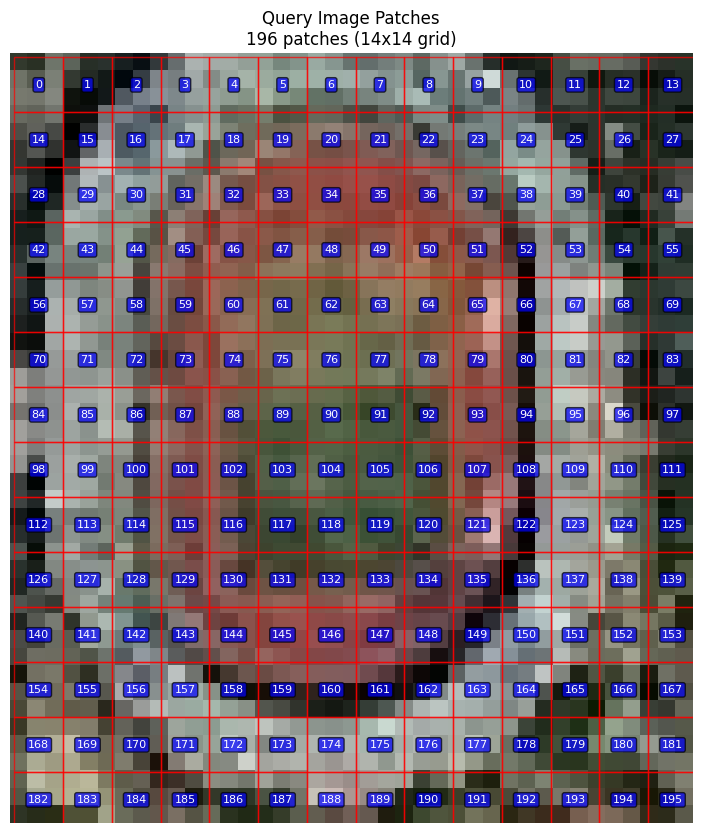

Image size: (78, 88)
Patch size: 5.6 x 6.3 pixels
Total patches: 196


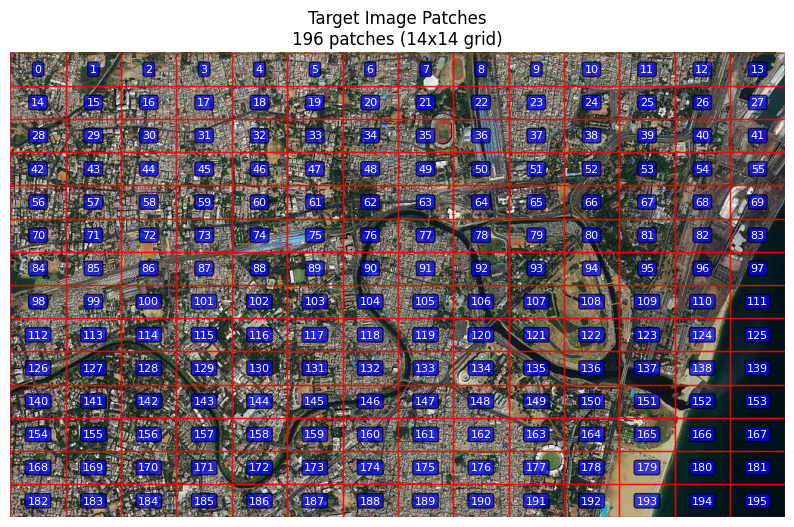

Image size: (1024, 614)
Patch size: 73.1 x 43.9 pixels
Total patches: 196

=== Testing Different Thresholds ===
Testing query: /content/dataset_eurosat_sample/01.png
Against target: /content/dataset_eurosat_sample/hi.jpg
Query image patches: 196 patches
Query patch embedding shape: (196, 1024)
Target image patches in index: 0
ERROR: Target image not found in patch index!


TypeError: object of type 'NoneType' has no len()

In [11]:
# Single Image Patch Testing Code
# Run this in a separate cell after running the main CBIR system

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import torch

def test_single_image_patches(query_image_path, target_image_path,
                             feature_extractor, patch_index, transform,
                             similarity_threshold=0.3):
    """
    Test patch matching between a query image and a specific target image.
    This helps debug why certain images might not show patch matches.
    """
    print(f"Testing query: {query_image_path}")
    print(f"Against target: {target_image_path}")

    # Load images
    query_image = Image.open(query_image_path).convert('RGB')
    target_image = Image.open(target_image_path).convert('RGB')

    # Process query image
    query_tensor = transform(query_image).unsqueeze(0).to(device)

    feature_extractor.eval()
    with torch.no_grad():
        # Extract query patches
        query_patch_embeddings, query_positions = feature_extractor.extract_patch_embeddings(query_tensor)
        query_patch_embeddings_np = normalize(query_patch_embeddings.cpu().numpy(), norm='l2')

    print(f"Query image patches: {len(query_patch_embeddings_np)} patches")
    print(f"Query patch embedding shape: {query_patch_embeddings_np.shape}")

    # Find all patches from the target image in the index
    target_patches = []
    for i, metadata in enumerate(patch_index.patch_metadata):
        if target_image_path in metadata['image_path']:
            target_patches.append({
                'patch_idx': i,
                'position': metadata['position'],
                'embedding_idx': i
            })

    print(f"Target image patches in index: {len(target_patches)}")

    if len(target_patches) == 0:
        print("ERROR: Target image not found in patch index!")
        return

    # Test each query patch against all target patches
    matches = []
    for q_idx, query_patch in enumerate(query_patch_embeddings_np):
        best_match = None
        best_similarity = -1

        # Search in the entire index to get top matches
        distances, indices, metadata = patch_index.search(query_patch.reshape(1, -1), k=100)

        # Check if any of the top matches are from our target image
        for dist, idx, meta in zip(distances, indices, metadata):
            if meta and target_image_path in meta['image_path']:
                if dist > best_similarity:
                    best_similarity = dist
                    best_match = {
                        'query_pos': query_positions[q_idx],
                        'target_pos': meta['position'],
                        'similarity': dist,
                        'patch_idx': idx
                    }
                break

        if best_match and best_similarity > similarity_threshold:
            matches.append(best_match)

    print(f"Found {len(matches)} matches above threshold {similarity_threshold}")

    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Show query image with matched patches
    axes[0].imshow(query_image)
    axes[0].set_title(f'Query Image\n{len(matches)} patches matched')

    img_w, img_h = query_image.size
    patch_w = img_w / 14
    patch_h = img_h / 14

    for match in matches:
        y, x = match['query_pos']
        similarity = match['similarity']

        color = 'red' if similarity > 0.8 else 'orange' if similarity > 0.6 else 'yellow'

        rect = patches.Rectangle(
            (x * patch_w, y * patch_h), patch_w, patch_h,
            linewidth=2, edgecolor=color, facecolor='none', alpha=0.8
        )
        axes[0].add_patch(rect)

        axes[0].text(x * patch_w + patch_w/2, y * patch_h + patch_h/2,
                    f'{similarity:.2f}', color='white', fontsize=8,
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))

    axes[0].axis('off')

    # Show target image with matched patches
    axes[1].imshow(target_image)
    axes[1].set_title(f'Target Image\n{len(matches)} patches matched')

    img_w, img_h = target_image.size
    patch_w = img_w / 14
    patch_h = img_h / 14

    for match in matches:
        y, x = match['target_pos']
        similarity = match['similarity']

        color = 'red' if similarity > 0.8 else 'orange' if similarity > 0.6 else 'yellow'

        rect = patches.Rectangle(
            (x * patch_w, y * patch_h), patch_w, patch_h,
            linewidth=2, edgecolor=color, facecolor='none', alpha=0.8
        )
        axes[1].add_patch(rect)

        axes[1].text(x * patch_w + patch_w/2, y * patch_h + patch_h/2,
                    f'{similarity:.2f}', color='white', fontsize=8,
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))

    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed match information
    if matches:
        print("\nDetailed matches:")
        for i, match in enumerate(matches):
            print(f"  Match {i+1}: Query patch {match['query_pos']} -> "
                  f"Target patch {match['target_pos']}, Similarity: {match['similarity']:.3f}")
    else:
        print("\nNo matches found above threshold!")

        # Show top similarities regardless of threshold
        print("\nTop 5 similarities (regardless of threshold):")
        all_similarities = []
        for q_idx, query_patch in enumerate(query_patch_embeddings_np):
            distances, indices, metadata = patch_index.search(query_patch.reshape(1, -1), k=50)
            for dist, idx, meta in zip(distances, indices, metadata):
                if meta and target_image_path in meta['image_path']:
                    all_similarities.append({
                        'query_pos': query_positions[q_idx],
                        'target_pos': meta['position'],
                        'similarity': dist
                    })

        all_similarities.sort(key=lambda x: x['similarity'], reverse=True)
        for i, sim in enumerate(all_similarities[:5]):
            print(f"  {i+1}. Query {sim['query_pos']} -> Target {sim['target_pos']}: {sim['similarity']:.3f}")

    return matches

def visualize_image_patches(image_path, feature_extractor, transform, title="Image Patches"):
    """
    Visualize all patches in a single image to understand the patch grid.
    """
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    feature_extractor.eval()
    with torch.no_grad():
        patch_embeddings, positions = feature_extractor.extract_patch_embeddings(image_tensor)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(f'{title}\n{len(positions)} patches (14x14 grid)')

    img_w, img_h = image.size
    patch_w = img_w / 14
    patch_h = img_h / 14

    # Draw grid and number each patch
    for i, (y, x) in enumerate(positions):
        rect = patches.Rectangle(
            (x * patch_w, y * patch_h), patch_w, patch_h,
            linewidth=1, edgecolor='red', facecolor='none', alpha=0.7
        )
        plt.gca().add_patch(rect)

        # Add patch number
        plt.text(x * patch_w + patch_w/2, y * patch_h + patch_h/2,
                str(i), color='white', fontsize=8,
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='blue', alpha=0.7))

    plt.axis('off')
    plt.show()

    print(f"Image size: {image.size}")
    print(f"Patch size: {patch_w:.1f} x {patch_h:.1f} pixels")
    print(f"Total patches: {len(positions)}")

# Example usage:
# Replace these paths with your actual image paths

print("=== Testing Single Image Patch Matching ===")

# Example 1: Test against a specific image
query_path = "/content/dataset_eurosat_sample/01.png"  # Your query (screenshot)
target_path = "/content/dataset_eurosat_sample/hi.jpg"  # Image you expect to match

matches = test_single_image_patches(
    query_path, target_path,
    patch_extractor, patch_index, transform,
    similarity_threshold=0.3
)

print("\n=== Visualizing Patch Grids ===")

# Example 2: Visualize patch grid for query image
visualize_image_patches(query_path, patch_extractor, transform, "Query Image Patches")

# Example 3: Visualize patch grid for target image
visualize_image_patches(target_path, patch_extractor, transform, "Target Image Patches")

# Example 4: Test with different threshold values
print("\n=== Testing Different Thresholds ===")
for threshold in [0.1, 0.3, 0.5, 0.7]:
    matches = test_single_image_patches(
        query_path, target_path,
        patch_extractor, patch_index, transform,
        similarity_threshold=threshold
    )
    print(f"Threshold {threshold}: {len(matches)} matches\n")

Using device: cpu
Initializing fixed patch-based CBIR system...
Found 82 images in /content/dataset_eurosat_sample
Loading unified patch feature extractor...
Loading existing patch FAISS index...
Patch index loaded. Total patches: 16072

Running patch-based search with MAX aggregation:

Searching with patch-based query (aggregation: max)...
Query patch embeddings shape: (196, 1024)
Patch index embedding dim: 1024
Query vector shape after max aggregation: (1, 1024)

Found 6 images with matching patches:
  1. 01.png: 43 patches matched, best similarity = 0.520, avg similarity = 0.500
  2. Residential_Residential_216.jpg: 1 patches matched, best similarity = 0.499, avg similarity = 0.499
  3. Residential_Residential_534.jpg: 2 patches matched, best similarity = 0.497, avg similarity = 0.494
  4. River_River_2452.jpg: 1 patches matched, best similarity = 0.489, avg similarity = 0.489
  5. Residential_Residential_1936.jpg: 2 patches matched, best similarity = 0.489, avg similarity = 0.489
 

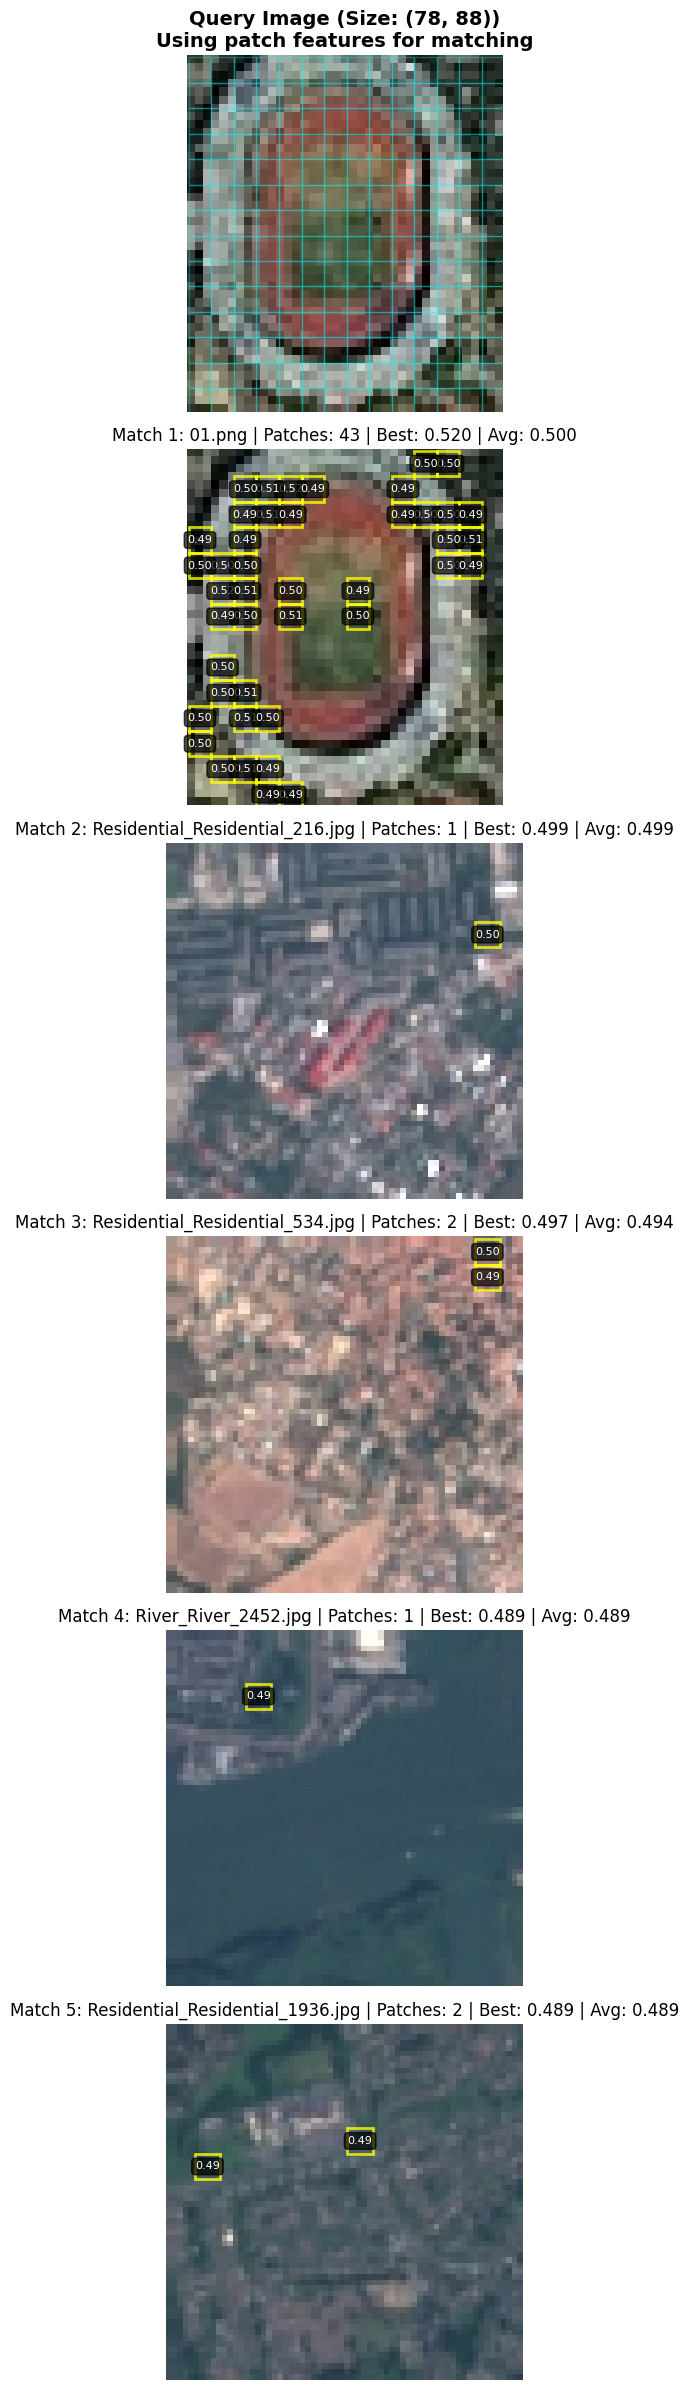

In [15]:
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import tifffile
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional
from tqdm import tqdm
from sklearn.preprocessing import normalize
import faiss
import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------------- Config ----------------------------
class Config:
    DATASET_PATH = "/content/dataset_eurosat_sample"
    CACHE_DIR = "cbir_cache_patch/"
    IMAGE_SIZE = (224, 224)  # Input size for ResNet
    BATCH_SIZE = 8
    NUM_WORKERS = 4
    MODEL_NAME = "resnet50"

    # Unified patch-based retrieval settings - using same layer for consistency
    FEATURE_MAP_LEVEL = "layer3"  # use layer3 for both patches and queries
    PATCH_EMBEDDING_DIM = 1024    # layer3 has 1024 channels
    TOP_K = 50  # Increased to get more patch matches
    SIMILARITY_THRESHOLD = 0.3

    # Feature map spatial dimensions for ResNet50 with 224x224 input
    FEATURE_MAP_SIZE = 14  # layer3 outputs 14x14 grid
    RECEPTIVE_FIELD_SIZE = 16

    IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp')

os.makedirs(Config.CACHE_DIR, exist_ok=True)

# ---------------------------- Helper Functions ----------------------------
def load_satellite_image(image_path: str) -> np.ndarray:
    """Load satellite image and convert to RGB numpy array."""
    try:
        if image_path.lower().endswith(('.tif', '.tiff')):
            img = tifffile.imread(image_path)
            if img.ndim == 3:
                if img.shape[0] < img.shape[2]:
                    img = np.transpose(img, (1, 2, 0))
                if img.shape[2] >= 3:
                    img = img[:, :, :3]
                else:
                    img = np.stack([img[:, :, 0]] * 3, axis=2)
            elif img.ndim == 2:
                img = np.stack([img] * 3, axis=2)
            if img.dtype != np.uint8:
                img = ((img - img.min()) / (img.max() - img.min() + 1e-6) * 255).astype(np.uint8)
            return img
        else:
            img = Image.open(image_path).convert('RGB')
            return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return np.zeros((224, 224, 3), dtype=np.uint8)

# ---------------------------- Dataset ----------------------------
class SatelliteImageDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, extensions=Config.IMAGE_EXTENSIONS):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = self._find_images(extensions)
        self.images_cache = {}
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def _find_images(self, extensions: tuple) -> List[Path]:
        image_paths = []
        for ext in extensions:
            image_paths.extend(self.root_dir.glob(f"**/*{ext}"))
            image_paths.extend(self.root_dir.glob(f"**/*{ext.upper()}"))
        return sorted(list(set(image_paths)))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        img_path = self.image_paths[idx]
        if idx not in self.images_cache:
            img_array = load_satellite_image(str(img_path))
            self.images_cache[idx] = img_array
        else:
            img_array = self.images_cache[idx]

        img = Image.fromarray(img_array)
        original_size = img.size

        if self.transform:
            img_tensor = self.transform(img)
        else:
            img_tensor = transforms.ToTensor()(img)

        return {
            'image': img_tensor,
            'path': str(img_path),
            'idx': idx,
            'original_size': original_size
        }

    def get_raw_image(self, idx: int) -> np.ndarray:
        if idx not in self.images_cache:
            img_path = self.image_paths[idx]
            self.images_cache[idx] = load_satellite_image(str(img_path))
        return self.images_cache[idx]

# ---------------------------- Feature Extractor ----------------------------
class PatchFeatureExtractor(nn.Module):
    """
    Extract patch features from ResNet layer3 for both database and queries.
    """
    def __init__(self, model_name: str = 'resnet50', pretrained: bool = True):
        super().__init__()

        if model_name == 'resnet50':
            base_model = models.resnet50(pretrained=pretrained)
            # Extract features up to layer3
            self.conv1 = base_model.conv1
            self.bn1 = base_model.bn1
            self.relu = base_model.relu
            self.maxpool = base_model.maxpool
            self.layer1 = base_model.layer1
            self.layer2 = base_model.layer2
            self.layer3 = base_model.layer3  # 1024 channels, 14x14

            self.patch_dim = 1024
            self.feature_map_size = 14
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def forward_to_layer3(self, x: torch.Tensor) -> torch.Tensor:
        """Extract feature map from layer3."""
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

    def extract_patch_embeddings(self, x: torch.Tensor) -> Tuple[torch.Tensor, List[Tuple[int, int]]]:
        """Extract patch embeddings from layer3."""
        feature_map = self.forward_to_layer3(x)
        B, C, H, W = feature_map.shape

        patch_embeddings = feature_map.permute(0, 2, 3, 1).reshape(-1, C)

        positions = []
        for b in range(B):
            for y in range(H):
                for x_pos in range(W):
                    positions.append((y, x_pos))

        return patch_embeddings, positions

# ---------------------------- FAISS Index for Patches ----------------------------
class PatchFAISSIndex:
    def __init__(self, embedding_dim: int, similarity_metric: str = 'cosine'):
        self.embedding_dim = embedding_dim
        self.similarity_metric = similarity_metric

        if similarity_metric == 'cosine':
            self.index = faiss.IndexFlatIP(embedding_dim)
        elif similarity_metric == 'l2':
            self.index = faiss.IndexFlatL2(embedding_dim)
        else:
            raise ValueError(f"Unsupported metric: {similarity_metric}")

        self.is_trained = False
        self.patch_metadata = []

    def build_from_patches(self, patch_embeddings: np.ndarray,
                          image_paths: List[str],
                          image_indices: List[int],
                          positions: List[Tuple[int, int]]):
        patch_embeddings = patch_embeddings.astype(np.float32)
        if self.similarity_metric == 'cosine':
            patch_embeddings = normalize(patch_embeddings, norm='l2')

        self.index.add(patch_embeddings)

        patches_per_image = len(positions) // len(image_paths)
        for img_idx, (img_path, img_index) in enumerate(zip(image_paths, image_indices)):
            for pos_idx in range(patches_per_image):
                y, x = positions[img_idx * patches_per_image + pos_idx]
                self.patch_metadata.append({
                    'image_path': img_path,
                    'image_idx': img_index,
                    'position': (y, x)
                })

        self.is_trained = True
        print(f"Patch index built with {self.index.ntotal} patches from {len(image_paths)} images")

    def search(self, query_embedding: np.ndarray, k: int = 10) -> Tuple[np.ndarray, np.ndarray, List[Dict]]:
        if not self.is_trained:
            raise ValueError("Index not built yet.")

        if query_embedding.ndim == 1:
            query_embedding = query_embedding.reshape(1, -1)

        query_embedding = query_embedding.astype(np.float32)
        if self.similarity_metric == 'cosine':
            query_embedding = normalize(query_embedding, norm='l2')

        distances, indices = self.index.search(query_embedding, k)

        matched_metadata = []
        for idx in indices[0]:
            if idx < len(self.patch_metadata):
                matched_metadata.append(self.patch_metadata[idx])
            else:
                matched_metadata.append(None)

        return distances[0], indices[0], matched_metadata

    def save(self, path: str):
        faiss.write_index(self.index, path)
        metadata_path = path.replace('.index', '_metadata.pkl')
        with open(metadata_path, 'wb') as f:
            pickle.dump(self.patch_metadata, f)
        print(f"Patch index saved to {path}")

    def load(self, path: str):
        self.index = faiss.read_index(path)
        self.is_trained = True
        metadata_path = path.replace('.index', '_metadata.pkl')
        if os.path.exists(metadata_path):
            with open(metadata_path, 'rb') as f:
                self.patch_metadata = pickle.load(f)
        print(f"Patch index loaded. Total patches: {self.index.ntotal}")

# ---------------------------- Extraction and Search Functions ----------------------------
def extract_dataset_patch_embeddings(feature_extractor: PatchFeatureExtractor,
                                    dataloader: DataLoader,
                                    cache_path: str = None) -> Tuple[np.ndarray, List[str], List[int], List[Tuple[int, int]]]:
    if cache_path and os.path.exists(cache_path):
        data = np.load(cache_path, allow_pickle=True)
        return (data['embeddings'],
                data['paths'].tolist(),
                data['indices'].tolist(),
                [tuple(p) for p in data['positions']])

    embeddings_list = []
    paths_list = []
    indices_list = []
    all_positions = []

    feature_extractor.eval()
    with torch.no_grad():
        for batch_data in tqdm(dataloader, desc="Extracting patch features"):
            images = batch_data['image'].to(device)

            patch_embeddings, positions = feature_extractor.extract_patch_embeddings(images)
            patch_embeddings_np = normalize(patch_embeddings.detach().cpu().numpy(), norm='l2')

            batch_size = images.size(0)
            patches_per_image = len(positions) // batch_size

            for i in range(batch_size):
                start_idx = i * patches_per_image
                end_idx = (i + 1) * patches_per_image
                image_patches = patch_embeddings_np[start_idx:end_idx]
                embeddings_list.append(image_patches)

                paths_list.append(batch_data['path'][i])
                indices_list.append(batch_data['idx'][i].item())
                all_positions.extend(positions[start_idx:end_idx])

    embeddings = np.vstack(embeddings_list)

    if cache_path:
        np.savez_compressed(cache_path,
                          embeddings=embeddings,
                          paths=np.array(paths_list),
                          indices=np.array(indices_list),
                          positions=np.array(all_positions))

    return embeddings, paths_list, indices_list, all_positions

def search_patches_with_patch_query(query_image: Image.Image,
                                   feature_extractor: PatchFeatureExtractor,
                                   patch_index: PatchFAISSIndex,
                                   transform,
                                   top_k: int = 50,
                                   threshold: float = 0.3,
                                   aggregation: str = 'average') -> List[Dict]:
    """
    CORRECTED APPROACH:
    - Extract PATCH features from query image (layer3)
    - Compare against individual PATCHES in the database (also layer3)
    - Use same dimensional features for fair comparison
    """
    query_tensor = transform(query_image).unsqueeze(0).to(device)

    feature_extractor.eval()
    with torch.no_grad():
        # Extract patch features from query (layer3)
        query_patch_embeddings, query_positions = feature_extractor.extract_patch_embeddings(query_tensor)
        query_patch_embeddings_np = normalize(query_patch_embeddings.detach().cpu().numpy(), norm='l2')

    print(f"Query patch embeddings shape: {query_patch_embeddings_np.shape}")
    print(f"Patch index embedding dim: {patch_index.embedding_dim}")

    # Aggregate query patches to create a single query vector
    if aggregation == 'average':
        query_vector = np.mean(query_patch_embeddings_np, axis=0, keepdims=True)
    elif aggregation == 'max':
        query_vector = np.max(query_patch_embeddings_np, axis=0, keepdims=True)
    elif aggregation == 'first':
        query_vector = query_patch_embeddings_np[0:1]  # Use first patch
    else:
        raise ValueError(f"Unsupported aggregation method: {aggregation}")

    print(f"Query vector shape after {aggregation} aggregation: {query_vector.shape}")

    # Search for similar patches
    distances, indices, metadata = patch_index.search(query_vector, k=top_k)

    # Group results by image
    image_matches = {}
    for dist, idx, meta in zip(distances, indices, metadata):
        if meta is None or dist < threshold:
            continue

        img_path = meta['image_path']
        if img_path not in image_matches:
            image_matches[img_path] = {
                'path': img_path,
                'image_idx': meta['image_idx'],
                'patches': []
            }

        image_matches[img_path]['patches'].append({
            'position': meta['position'],
            'similarity': float(dist),
            'patch_idx': int(idx)
        })

    # Convert to list and sort
    results = list(image_matches.values())
    for result in results:
        result['best_similarity'] = max(p['similarity'] for p in result['patches'])
        result['avg_similarity'] = sum(p['similarity'] for p in result['patches']) / len(result['patches'])

    results.sort(key=lambda x: x['best_similarity'], reverse=True)

    return results

def visualize_patch_matches(query_image: Image.Image,
                           search_results: List[Dict],
                           feature_map_size: int = 14,
                           top_k_images: int = None,
                           show_query_patches: bool = True):
    """Visualize query image and matched patches in target images."""
    n_results = len(search_results) if top_k_images is None else min(len(search_results), top_k_images)

    fig = plt.figure(figsize=(20, 4 * (n_results + 1)))

    # Show query image with patch grid
    ax = plt.subplot(n_results + 1, 1, 1)
    plt.imshow(query_image)

    if show_query_patches:
        img_w, img_h = query_image.size
        patch_w = img_w / feature_map_size
        patch_h = img_h / feature_map_size

        # Draw patch grid on query image
        for y in range(feature_map_size):
            for x in range(feature_map_size):
                rect = patches.Rectangle(
                    (x * patch_w, y * patch_h),
                    patch_w, patch_h,
                    linewidth=1,
                    edgecolor='cyan',
                    facecolor='none',
                    alpha=0.3
                )
                ax.add_patch(rect)

    plt.title(f'Query Image (Size: {query_image.size})\nUsing patch features for matching',
              fontsize=14, fontweight='bold')
    plt.axis('off')

    # Show matched images with highlighted patches
    for idx, result in enumerate(search_results[:n_results]):
        ax = plt.subplot(n_results + 1, 1, idx + 2)
        matched_img = Image.open(result['path']).convert('RGB')
        plt.imshow(matched_img)

        img_w, img_h = matched_img.size
        patch_w = img_w / feature_map_size
        patch_h = img_h / feature_map_size

        # Highlight matched patches
        for patch_info in result['patches']:
            y, x = patch_info['position']
            similarity = patch_info['similarity']

            color = 'red' if similarity > 0.8 else 'orange' if similarity > 0.6 else 'yellow'

            rect = patches.Rectangle(
                (x * patch_w, y * patch_h),
                patch_w, patch_h,
                linewidth=2,
                edgecolor=color,
                facecolor='none',
                alpha=0.8
            )
            ax.add_patch(rect)

            ax.text(x * patch_w + patch_w/2, y * patch_h + patch_h/2,
                   f'{similarity:.2f}',
                   color='white',
                   fontsize=8,
                   ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

        plt.title(f'Match {idx+1}: {os.path.basename(result["path"])} | '
                 f'Patches: {len(result["patches"])} | Best: {result["best_similarity"]:.3f} | '
                 f'Avg: {result["avg_similarity"]:.3f}',
                 fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# ---------------------------- Main Pipeline ----------------------------
def get_transforms():
    return transforms.Compose([
        transforms.Resize(Config.IMAGE_SIZE),
        transforms.CenterCrop(Config.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

print("Initializing fixed patch-based CBIR system...")
transform = get_transforms()
dataset = SatelliteImageDataset(Config.DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=False,
                        num_workers=0, pin_memory=torch.cuda.is_available())

print("Loading unified patch feature extractor...")
feature_extractor = PatchFeatureExtractor(model_name=Config.MODEL_NAME, pretrained=True).to(device)

patch_embeddings_path = os.path.join(Config.CACHE_DIR, 'patch_embeddings_fixed.npz')
patch_embeddings, image_paths, image_indices, positions = extract_dataset_patch_embeddings(
    feature_extractor, dataloader, cache_path=patch_embeddings_path
)

patch_index_path = os.path.join(Config.CACHE_DIR, 'patch_faiss_fixed.index')
patch_index = PatchFAISSIndex(embedding_dim=Config.PATCH_EMBEDDING_DIM, similarity_metric='cosine')

if not os.path.exists(patch_index_path):
    print("Building patch FAISS index...")
    patch_index.build_from_patches(patch_embeddings, image_paths, image_indices, positions)
    patch_index.save(patch_index_path)
else:
    print("Loading existing patch FAISS index...")
    patch_index.load(patch_index_path)

def run_fixed_patch_search(query_image_path: str = None, aggregation: str = 'average'):
    """
    Run patch-based search with proper feature alignment.

    Args:
        query_image_path: Path to query image
        aggregation: How to aggregate query patches ('average', 'max', 'first')
    """
    if query_image_path is None:
        query_image_path = image_paths[0]
        print(f"No query provided. Using example: {query_image_path}")

    query_image = Image.open(query_image_path).convert('RGB')

    print(f"\nSearching with patch-based query (aggregation: {aggregation})...")
    search_results = search_patches_with_patch_query(
        query_image,
        feature_extractor,
        patch_index,
        transform,
        top_k=Config.TOP_K,
        threshold=Config.SIMILARITY_THRESHOLD,
        aggregation=aggregation
    )

    print(f"\nFound {len(search_results)} images with matching patches:")
    for i, result in enumerate(search_results[:10]):
        print(f"  {i+1}. {os.path.basename(result['path'])}: "
              f"{len(result['patches'])} patches matched, "
              f"best similarity = {result['best_similarity']:.3f}, "
              f"avg similarity = {result['avg_similarity']:.3f}")

    if len(search_results) > 10:
        print(f"  ... and {len(search_results) - 10} more images")

    visualize_patch_matches(query_image, search_results,
                           feature_map_size=Config.FEATURE_MAP_SIZE,
                           top_k_images=5)  # Show top 5 matches

    return search_results

print("\n" + "="*80)
print("Running patch-based search with MAX aggregation:")
results_max = run_fixed_patch_search("/content/dataset_eurosat_sample/01.png", aggregation='max')